## Motivation

Our objective is to derive the adjoint

$$ \lambda_t = \frac{d J}{d x(t)} $$

In a more efficient, approximate way (using ML). 


We previously computed it using

$$ \textcolor{red}{\lambda_{t}} = \frac{\partial J}{ \partial x(t)} + \frac{dx(t+1) }{dx(t)} \textcolor{red}{\lambda_{t+1}}$$

Initializing the process with the final timestep, $\tau$: $\lambda_{\tau} = dJ/dx(\tau)$. 

## Observing our Linear Model

Which component do we want to optimize? Let's look at each term, considering timestep $t=\tau-1$.

- $\lambda_\tau = dJ/dx(\tau)$. We'll assume that $J$ is a squared-loss function between our observed state and the simulated one. 

$$J = \sum_{t=1}^{\tau}
      \Big( z(t) - x(t) \Big)^\top W^{-1}
      \Big( z(t) - x(t) \Big)$$

If we take the derivative:

$$\frac{dJ}{dx(\tau)} = 
      2W^{-1}
      \Big( z(\tau) - x(\tau) \Big)$$

This only requires a single matrix subtraction and multiplication: an ML model wouldn't do this any faster.


This only requires some matrix: an ML model wouldn't do this any faster.

- $\partial J / \partial x(\tau - 1)$: another squared-loss function. By exactly the same logic, we don't benefit from optimizing this: the equation we get is almost identical, substituting $\tau$ with $\tau-1$.

- $dx(\tau)/dx(\tau-1)$. We could use our previous function for time-evolving our system:

$$x(t+1) = Mx(t) + Ff(t)$$

But wait. The derivative is simple for this one too:

$$ \frac{dx(\tau) }{dx(\tau-1)} = M^\top $$

Just a simple matrix transpose. None of our terms can be optimized by switching to a neural network.

## A more complex model


So, ML doesn't really benefit our current setup. But that's because our system is just too simplified: this would be more suitable for something more complex. So, let's get a bit more general.

What aspect of our system needs to be more complex? Well, it's unclear how we could "improve" our loss function: we don't have any reason to think square distance is "wrong" for measuring the accuracy of our simulation. In other words: we don't need to make $\partial J/ \partial x(t)$ more complex.

Our other term is more relevant: $dx(t+1)/dx(t)$. We're comparing our state over time: this comes from our *model*.

What do we mean by model? We mean the evolution of our system, according to physics over time. This is something we can naturally make more accurate: we can use a more accurate physics simulation! 

- This "more accurate" physics simulation is what we will approximate with a neural network: how our state evolved in time.
- More precisely, we'll use a neural net to estimate $dx(t+1)/dx(t)$.

### Model $M$

Let's start talking about this generally: we start with our specific example, and broaden it to include other models.

Our "model" $M$ tells us how our state evolves in time. Given a state $x(t)$ and parameters $p(t)$, we get the state at the next timestep, $x(t+1)$. 

- Above, our parameters were our forcing $f$, which was constant in time. We can instead make this variable in time, creating a function $f(t)$.

- We actually had a bunch of other parameters, that we ignored: the diffusivity constants, for example. These could also vary with time: we can lump them all together under the parameter vector $p(t)$.

Suppose we have a length-$k$ state vector and length $\ell$ parameter vector. Then, our function is $M: \mathbf{R}^k \times \mathbf{R}^\ell \to \mathbf{R}^k$.

- To make things a little more readable, we'll create some simple notation for $x(t)$ and $p(t)$, calling them $x_t$ and $p_t$ instead.

$$ x_{t+1} = M(x_t, p_t)$$

In our previous examples, our model was an affine one: it could be handled by matrix multiplication and addition.

Now, we allow it to be more general: it could be some other, more complex function. Our derivative is no longer something we can compute the answer to so easily:

$$ \frac{dx_{t+1} }{dx_t} = \frac{d M(x_t, p_t)}{dx_t} = ???$$

### New value to solve for

We have one problem: $dx_{t+1}/dx_t$ is a huge matrix. If our state vector is $k \times 1$, it'll be $k^2$. Since $k=n_rn_c$, if we have a square map $n \times n$, the derivative grows as $n^4$.

This is a serious memory concern. So, we want to avoid storing a huge matrix like that.

Instead, we refer back to our original equation:

$$ \lambda_{t} = \frac{\partial J}{ \partial x_t} + \frac{dx_{t+1} }{dx_t} \lambda_{t+1}$$

Rather than directly solving for $dx_{t+1}/dx_t$, we might solve for something in a better shape:

- $\frac{dx_{t+1} }{dx_t} \lambda_{t+1}$ is $k \times 1$.
- Or, we could directly try solving for $\lambda_t$.

Both of these could work, but it seems unnecessary to train our model to add $dJ/dx(t)$, so we'll start by instead using the first approach.



## Our Neural Network 

To reiterate, we want to train a model to predict $\frac{dx_{t+1} }{dx_t} \lambda_{t+1}$. 

- Given that $M$ is a function of $x_t$ and $p_t$, we would also expect the same of $\frac{dx_{t+1} }{dx_t}=\frac{d M(x_t, p_t)}{dx_t}$. 

- $\lambda_{t+1}$ is presumably a value we've already calculated (working inductively), so we'll just plug this in as another input.

We know our inputs ($x_t$,$p_t$, $\lambda_{t+1}$) and our desired output $\frac{dx_{t+1} }{dx_t}\lambda_{t+1}$. Based on this, we can set up a supervised learning problem. 


### Our initial setup

To test this out, we'll actually begin with our over-simplified, redundant case: the affine model.

- This way, we can check whether we're getting the right answer.

We'll need a loss function to measure the error of our loss function. Once again, we use the squared distance loss function: the difference between the true value of $dx(t+1)/dx(t)$, versus the one predicted by our network.

$$L = \Big( h(x_t,p_t, \lambda_{t+1}) - \frac{dx_{t+1} }{dx_t} \lambda_{t+1} \Big)^\top \Big( h(x_t,p_t, \lambda_{t+1}) - \frac{dx_{t+1} }{dx_t} \lambda_{t+1} \Big)$$

# Ver 0: Randomized Output+Parameters

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, Tuple, List
import helper
import matplotlib.pyplot as plt

In [2]:


class LinearModelDataset(Dataset):
    def __init__(self, num_samples: int, nr: int, nc: int, dt: float, F: float):
        self.num_samples = num_samples
        self.nr = nr
        self.nc = nc
        self.dt = dt
        self.F = F
        self.samples = self._generate_samples()

    def _generate_samples(self) -> List[Tuple[Dict, torch.Tensor, torch.Tensor, torch.Tensor]]:
        samples = []
        for _ in range(self.num_samples):
            params = {
                'KX': torch.rand(self.nr, self.nc + 1),
                'KY': torch.rand(self.nr + 1, self.nc),
                'DX_C': torch.ones(self.nr, self.nc + 1),
                'DY_C': torch.ones(self.nr + 1, self.nc),
                'DX_G': torch.ones(self.nr + 1, self.nc),
                'DY_G': torch.ones(self.nr, self.nc + 1),
                'VX': torch.randn(self.nr, self.nc + 1) * 100,
                'VY': torch.randn(self.nr + 1, self.nc) * 100,
                'RAC': torch.ones(self.nr, self.nc),
                'f': torch.randn(self.nr * self.nc),
            }
            
            x_t = torch.randn(self.nr * self.nc)
            lambda_t_plus_1 = torch.randn(self.nr * self.nc)
            dx_dt_lambda = self._compute_dx_dt_lambda(params, x_t, lambda_t_plus_1)
            
            samples.append((params, x_t, lambda_t_plus_1, dx_dt_lambda))
        
        return samples

    def _compute_dx_dt_lambda(self, 
                              params: Dict[str, torch.Tensor], 
                              x_t: torch.Tensor, 
                              lambda_t_plus_1: torch.Tensor) -> torch.Tensor:
        return torch.randn(self.nr * self.nc)

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> Tuple[Dict[str, torch.Tensor], torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.samples[idx]

class LinearModelNet(torch.nn.Module):
    def __init__(self, nr: int, nc: int):
        super().__init__()
        self.nr = nr
        self.nc = nc
        
        self.state_size = nr * nc
        self.param_size = (nr * (nc + 1) +
                           (nr + 1) * nc +
                           nr * (nc + 1) +
                           (nr + 1) * nc +
                           (nr + 1) * nc +
                           nr * (nc + 1) +
                           nr * (nc + 1) +
                           (nr + 1) * nc +
                           nr * nc +
                           nr * nc)
        
        self.input_size = self.state_size * 2 + self.param_size
        self.output_size = nr * nc
        
        print(f"Input size: {self.input_size}")
        
        # Adjust the architecture to handle the correct input size
        self.fc1 = torch.nn.Linear(self.input_size, 2048)
        self.fc2 = torch.nn.Linear(2048, 1024)
        self.fc3 = torch.nn.Linear(1024, 512)
        self.fc4 = torch.nn.Linear(512, self.output_size)
        
        self.activation = torch.nn.ReLU()
        
    def forward(self, x: torch.Tensor, lambda_t_plus_1: torch.Tensor, params: Dict[str, torch.Tensor]) -> torch.Tensor:
        batch_size = x.size(0) 
        
        # Ensure all tensors have the correct batch size
        x = x.view(batch_size, -1)
        lambda_t_plus_1 = lambda_t_plus_1.view(batch_size, -1)
        
        # Flatten the params dictionary
        params_flat = torch.cat([param.view(batch_size, -1) for param in params.values()], dim=1)
        
        # Concatenate all inputs
        x = torch.cat([x, lambda_t_plus_1, params_flat], dim=1)
        
        # Add some debugging print statements
        #print(f"x shape: {x.shape}")
        #print(f"Input size: {self.input_size}")
        
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        
        return x

def train_model(model: torch.nn.Module, dataloader: DataLoader, num_epochs: int, learning_rate: float):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for params, x_t, lambda_t_plus_1, dx_dt_lambda in dataloader:
            optimizer.zero_grad()
            output = model(x_t, lambda_t_plus_1, params)
            loss = criterion(output, dx_dt_lambda)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")



Creating datasets...
Input size: 1280
Training started...
Epoch 1/10
Training Loss: 1.5115
Test Loss: 0.9850
Epoch 2/10
Training Loss: 1.0008
Test Loss: 0.9850
Epoch 3/10
Training Loss: 1.0005
Test Loss: 0.9849
Epoch 4/10
Training Loss: 1.0013
Test Loss: 0.9849
Epoch 5/10
Training Loss: 1.0006
Test Loss: 0.9849
Epoch 6/10
Training Loss: 1.0003
Test Loss: 0.9849
Epoch 7/10
Training Loss: 1.0001
Test Loss: 0.9849
Epoch 8/10
Training Loss: 0.9993
Test Loss: 0.9850
Epoch 9/10
Training Loss: 0.9999
Test Loss: 0.9850
Epoch 10/10
Training Loss: 0.9998
Test Loss: 0.9850
Training complete!


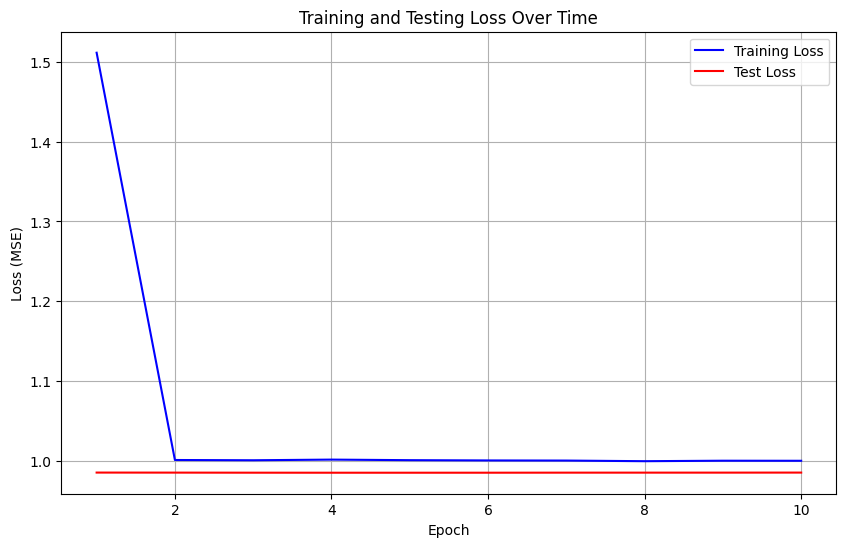


Comparison of first 10 values (from test set):
Index    True Value    Predicted   Difference
--------------------------------------------
0          0.753871    -0.026969     0.780839
1          1.581616     0.027113     1.554503
2         -0.631591    -0.004511    -0.627081
3         -1.250814     0.000093    -1.250907
4          1.641495    -0.035882     1.677377
5          2.032204     0.017489     2.014715
6          0.376345    -0.002093     0.378438
7         -0.917256    -0.007687    -0.909569
8         -0.889872     0.009569    -0.899441
9          0.304606     0.038935     0.265671

Test Set Statistics:
Mean Absolute Error: 0.835640
Root Mean Square Error: 1.015921
True vector norm: 10.149200
Predicted vector norm: 0.200095


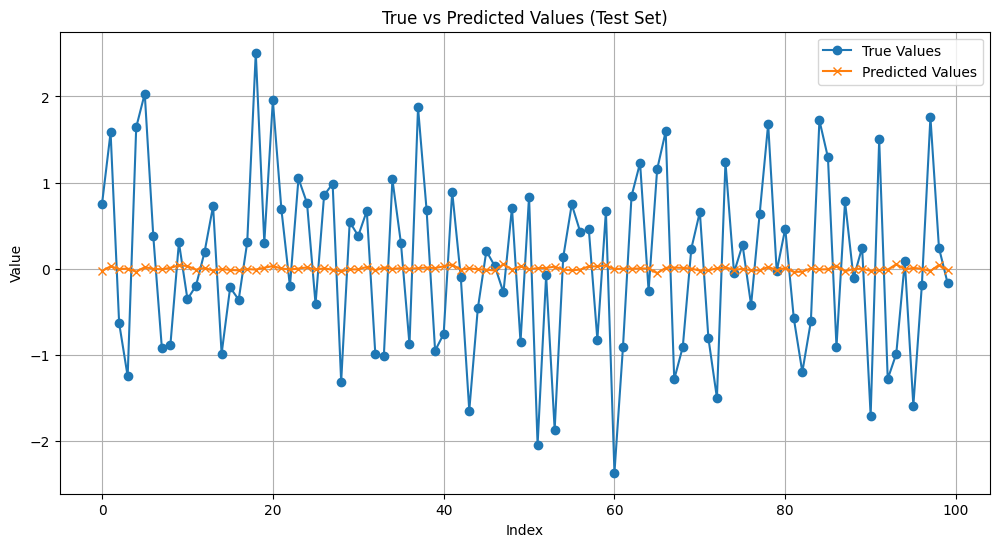

In [ ]:
if __name__ == "__main__":
    # Model parameters
    nr, nc = 10, 10
    dt = 0.1
    F = 1.0
    
    # Dataset parameters
    train_samples = 1800  
    test_samples = 200    
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001

    print("Creating datasets...")
    # Create datasets
    train_dataset = LinearModelDataset(train_samples, nr, nc, dt, F)
    test_dataset = LinearModelDataset(test_samples, nr, nc, dt, F)
    
    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create and train the model
    model = LinearModelNet(nr, nc)
    
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    # Lists to store losses for plotting
    train_losses = []
    test_losses = []
    
    print("Training started...")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for params, x_t, lambda_t_plus_1, dx_dt_lambda in train_dataloader:
            optimizer.zero_grad()
            output = model(x_t, lambda_t_plus_1, params)
            loss = criterion(output, dx_dt_lambda)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for params, x_t, lambda_t_plus_1, dx_dt_lambda in test_dataloader:
                output = model(x_t, lambda_t_plus_1, params)
                test_loss = criterion(output, dx_dt_lambda)
                total_test_loss += test_loss.item()
        
        # Store average losses
        avg_train_loss = total_train_loss/len(train_dataloader)
        avg_test_loss = total_test_loss/len(test_dataloader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Test Loss: {avg_test_loss:.4f}")
    
    print("Training complete!")

    # Plot training and testing losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss')
    plt.title('Training and Testing Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test examples
    model.eval()
    test_params, test_x, test_lambda, test_true = next(iter(test_dataloader))
    
    # Get model prediction for first test example
    with torch.no_grad():
        predicted = model(test_x[0:1], test_lambda[0:1], 
                        {k: v[0:1] for k, v in test_params.items()})

    # Remove batch dimension
    predicted = predicted.squeeze(0)
    test_true = test_true[0]  # Get first example's true values

    # Print comparison
    print(f"\nComparison of first 10 values (from test set):")
    print(f"{'Index':<6} {'True Value':>12} {'Predicted':>12} {'Difference':>12}")
    print("-" * 44)
    for i in range(10):
        print(f"{i:<6} {test_true[i]:>12.6f} {predicted[i]:>12.6f} {(test_true[i] - predicted[i]):>12.6f}")

    # Print overall statistics
    print(f"\nTest Set Statistics:")
    print(f"Mean Absolute Error: {torch.abs(test_true - predicted).mean():.6f}")
    print(f"Root Mean Square Error: {torch.sqrt(torch.mean((test_true - predicted)**2)):.6f}")
    print(f"True vector norm: {torch.norm(test_true):.6f}")
    print(f"Predicted vector norm: {torch.norm(predicted):.6f}")

    # Plot true vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_true.numpy(), label='True Values', marker='o')
    plt.plot(predicted.numpy(), label='Predicted Values', marker='x')
    plt.title('True vs Predicted Values (Test Set)')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

### To-do:

- Instead of random data, get data from actual climate simulation examples
- Train model on only one world
- Train model on many worlds